<h1>Blend3d</h1>
<p>Deep image blending on 3D textured meshes</p>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from pytorch3d.io import load_objs_as_meshes

In [2]:
sys.path.insert(
    0, os.path.abspath(os.path.join(os.getcwd(), "../../DermSynth3D_private"))
)

from dermsynth3d.tools.renderer import (
    MeshRendererPyTorch3D,
)
from dermsynth3d.deepblend.blend3d import Blended3d
from dermsynth3d.deepblend.blend import (
    DeepImageBlend,
    DeepTextureBlend3d,
)
from dermsynth3d.utils.filestruct import custom_directories

In [3]:
my_folders = custom_directories("jer")
print(my_folders)

/mnt/d/data/archive/House_Room_Dataset/Bedroom/
/mnt/d/data/3dbodytex-1.1-highres/3dbodytex-1.1-highres/
/mnt/d/data/3dbodytex-1.1-highres/3DBodyTex_nonskinfaces/3DBodyTex_nonskinfaces
/mnt/d/data/bodytex/bodytex_anatomy/bodytex_anatomy_labels
/mnt/d/data/fitzpatrick17k/data/finalfitz17k
/mnt/d/data/fitzpatrick17k/annotations/annotations-20220429T234131Z-001/annotations


In [4]:
# GPU/CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [5]:
EXPERIMENT_NAME = "tester"
mesh_filename = os.path.join(
    my_folders.bodytex_highres(), "221-m-u/model_highres_0_normalized.obj"
)

In [6]:
blended3d = Blended3d(
    mesh_filename=mesh_filename,
    # Directory to save the blended textures.
    dir_blended_textures=my_folders.new_textures(),
    # Directory of bodytex nonskin face indexes.
    dir_nonskin_faces=None,  #'../data/bodytex/nonskinfaces',
    # Extension to add to the texture image filename.
    extension=EXPERIMENT_NAME,
)

In [7]:
mesh = load_objs_as_meshes([mesh_filename], device=device)
mesh_renderer = MeshRendererPyTorch3D(
    mesh=mesh,
    device=device,
)

In [8]:
# Computes the deep blending loss.
deepblend = DeepImageBlend()

In [9]:
# Handles the blending process.
deepblend3d = DeepTextureBlend3d(
    blended3d,
    mesh_renderer,
    deepblend,
    device,
    view_size=(512, 512),
)
deepblend3d.blended3d.lesion_params().head()

,look_at,normal,camera_pos,normal_weight,max_depth_diff,lesion_mask_id,fitz_id
0,"[0.5806335, 0.14949255, -0.03545352]","[0.07758307, 0.9626253, 0.25948694]","[0.6142211934362081, 0.5650966339960433, 0.076...",0.431636,0.004061,1,0d8457afebb67905127da37baece43d8
1,"[0.45160365, 0.16170503, 0.28515106]","[0.247675, 0.83573556, 0.49010524]","[0.5719915482555649, 0.5676953011439128, 0.523...",0.485668,0.005246,2,0d90cd2b2bf339a587dd7072372ff186
2,"[1.432153, 0.083884835, -0.112745464]","[-0.053761363, -0.4393269, -0.8967171]","[1.4013192267403298, -0.1687995512137465, -0.6...",0.575390,0.008733,3,0b40c010e442d29b496fa8368746b02a
3,"[1.5562655, 0.08823033, -0.19880952]","[0.5676358, -0.78548473, 0.24658325]","[1.7942757827749958, -0.24088591327756398, -0....",0.419125,0.016574,4,1a3485252a20ba5b11e3958881f21b4e
4,"[0.3363813, 0.08113881, -0.07177762]","[-0.09212656, -0.8972659, 0.4317712]","[0.2812358704727805, -0.4568234658374547, 0.18...",0.599669,0.006802,5,0ef0d6fa3124b76205a8d514b22fafaa


In [10]:
optimizer = torch.optim.Adam([deepblend3d.texture_image.requires_grad_()], lr=0.005)

In [11]:
def closure():
    print_after_n_iterations = 25
    optimizer.zero_grad()
    loss = deepblend3d.compute_loss_of_random_offset_view()
    loss.backward()

    # Print Loss
    if run[0] % print_after_n_iterations == 0:
        step_idx = len(deepblend3d.deepblend.losses) - 1  # + run[0]
        print(
            "run: {}, loss: {:4f}, grad: {:4f}, style: {:4f}, content: {:4f}, tv: {:4f},".format(
                run,
                deepblend3d.deepblend.losses[step_idx]["loss"],
                deepblend3d.deepblend.losses[step_idx]["grad"],
                deepblend3d.deepblend.losses[step_idx]["style"],
                deepblend3d.deepblend.losses[step_idx]["content"],
                deepblend3d.deepblend.losses[step_idx]["tv"],
                # hist_loss.item(),
            )
        )

    run[0] += 1
    return loss

In [12]:
# For each lesion, run a separate optimization.
for row_idx, params in deepblend3d.blended3d.lesion_params().iterrows():
    deepblend3d.set_params(params)
    # print('Optimizing for face_idx = {}'.format(int(deepblend3d.params.face_idx)))
    print("Optimizing for row_idx = {}".format(row_idx))
    run = [0]
    n_iter = 25  # Suggest increasing to ~400 iterations.
    # n_iter = 400
    while run[0] <= n_iter:
        optimizer.step(closure)

Optimizing for row_idx = 0
run: [0], loss: 86.074867, grad: 81.936890, style: 4.027431, content: 0.000000, tv: 0.110552,
run: [25], loss: 28.483023, grad: 25.663580, style: 2.291284, content: 0.421088, tv: 0.107071,
Optimizing for row_idx = 1
run: [0], loss: 42.910526, grad: 41.777145, style: 1.036749, content: 0.000000, tv: 0.096630,
run: [25], loss: 8.478565, grad: 7.571586, style: 0.430405, content: 0.383402, tv: 0.093173,
Optimizing for row_idx = 2
run: [0], loss: 66.451523, grad: 64.190155, style: 2.106941, content: 0.000000, tv: 0.154428,
run: [25], loss: 10.576301, grad: 8.840872, style: 1.073968, content: 0.512257, tv: 0.149203,
Optimizing for row_idx = 3
run: [0], loss: 76.033890, grad: 64.689072, style: 10.929168, content: 0.000000, tv: 0.415652,
run: [25], loss: 20.260107, grad: 11.559039, style: 7.534455, content: 0.766522, tv: 0.400091,
Optimizing for row_idx = 4
run: [0], loss: 33.807281, grad: 30.405836, style: 3.269534, content: 0.000000, tv: 0.131912,
run: [25], loss: 

In [13]:
# Postprocess the blended textures
merged_texture_np = deepblend3d.postprocess_blended_texture_image()

In [14]:
# Save the final blended textures to disk.
blended3d.save_blended_texture_image(merged_texture_np, print_filename=True)

/mnt/d/data/3dbodytex-1.1-highres/3DBodyTex_nonskinfaces/3DBodyTex_nonskinfaces/221-m-u/model_highres_0_normalized_tester.png


<h2>You finished blending.</h2>
<p>The rest of the code is for visualization and debugging purposes.</p>

<AxesSubplot:>

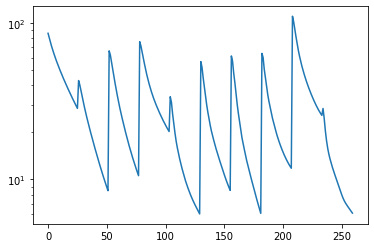

In [15]:
# Check the losses over iterations.
df_losses = pd.DataFrame(deepblend.losses)
df_losses.loss.plot(logy=True)

In [16]:
# Visualize the tensors that are being blended.
deepblend3d.texture_image.data.clamp_(0, 1)
deepblend3d.set_params(deepblend3d.blended3d.lesion_params().iloc[0])
deepblend3d.randomize_view_offset(offset=0)
tensors, gt_gradient = deepblend3d.render_texture_views()

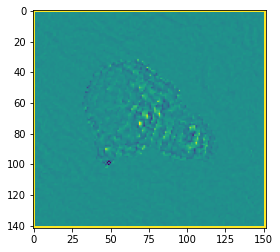

In [17]:
plt.imshow(gt_gradient[0].squeeze().cpu().detach().numpy(), vmin=-0.2, vmax=0.2)

In [18]:
tensors.keys()

dict_keys(['composite', 'original', 'mask', 'pasted'])

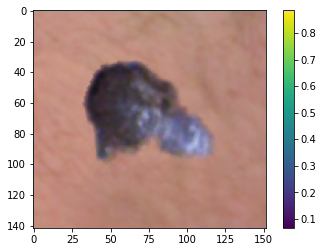

In [19]:
# Visualize the tensor of the region that is being blended.
from torchvision import transforms

blended = np.asarray(transforms.ToPILImage()(tensors["composite"].squeeze_(0))) / 255
# plt.figure(figsize=(12,12))
plt.imshow(blended)
plt.colorbar()

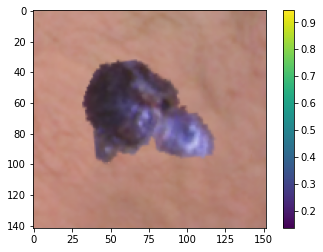

In [20]:
# Visualize the pasted lesion. These two images should look different
pasted = np.asarray(transforms.ToPILImage()(tensors["pasted"].squeeze_(0))) / 255
# plt.figure(figsize=(12,12))
plt.imshow(pasted)
plt.colorbar()

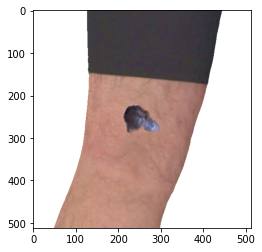

In [21]:
# Check how the full blended image looks.
deepblend3d.texture_image.data.clamp_(0, 1)
# Set renderer to original position.
deepblend3d.randomize_view_offset(offset=0)
deepblend3d.mesh_renderer.set_texture_image(texture_image=deepblend3d.texture_image)
img = deepblend3d.mesh_renderer.render_view(asnumpy=True, asRGB=True)
# plt.figure(figsize=(12,12))
plt.imshow(img)

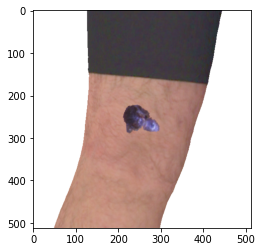

In [22]:
# Compare the pasted.
deepblend3d.mesh_renderer.set_texture_image(texture_image=deepblend3d.pasted_texture)
img = deepblend3d.mesh_renderer.render_view(asnumpy=True, asRGB=True)
# plt.figure(figsize=(12,12))
plt.imshow(img)